# 10-搖臂拉霸機測試環境（k-armed bandit problem）

In [4]:
# Step 1: Decide 動作值 q*(a)
import numpy as np
import matplotlib.pyplot as plt

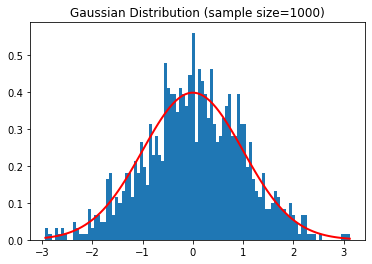

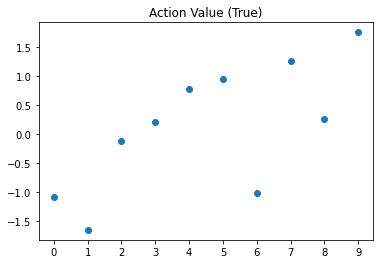

In [5]:
sample_size = 1000
sigma=1
mu=0
# loc: Mean ("centre") of the distribution
# scale: Standard deviation (Spread or "width") of the distribution. Must be non-negative.
gaussian_distribution = [np.random.normal(loc=mu, scale=sigma) for _ in range(sample_size)]

plt.title(f"Gaussian Distribution (sample size={sample_size})")
count, bins, ignored = plt.hist(gaussian_distribution, bins=100, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()

# Derive q*(a), a = a1, a2, a3, ..., a10
action_values_true = gaussian_distribution[:10]

plt.title("Action Value (True)")
plt.plot(action_values_true, "o")
plt.xticks(range(10))
plt.show()

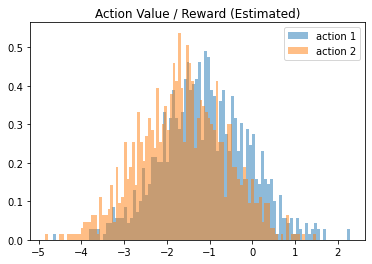

In [6]:
def get_act_reward(action_number):
    mu = action_values_true[action_number]
    sigma = 1
    return np.random.normal(loc=mu, scale=sigma)

def change_action_values_true():
    for i in range(10):
        mu = action_values_true[i]
        noise = np.random.normal(loc=0, scale=0.01)
        action_values_true[i] = mu + noise

# Action 1
action_1_distribution = [get_act_reward(0) for _ in range(sample_size)]

# Action 2
action_2_distribution = [get_act_reward(1) for _ in range(sample_size)]

plt.title("Action Value / Reward (Estimated)")
plt.hist(action_1_distribution, alpha=0.5, bins=100, density=True, label="action 1")
plt.hist(action_2_distribution, alpha=0.5, bins=100, density=True, label="action 2")
plt.legend()
plt.show()

我們可以測量此學習方法在 1000 個時步中逐步提昇的表現和行為。這構成了一個行程（Run）。將學習方法重複 2000 個獨立行程，且每個行程使用不同的拉霸機問題，我們將可以獲得學習演算法平均行為的評估。

學習方法
1. 貪婪方法（Greedy）
2. ɛ-貪婪方法（ɛ-Greedy, where ɛ=0.01）
3. ɛ-貪婪方法（ɛ-Greedy, where ɛ=0.1）

In [40]:
# =============== #
# 貪婪方法（Greedy）#
# =============== #
# 探索 100 次（Exploration）：先對每個 action 隨機抽取 10 次（共100次），平均後取得對該動作的估計值
# 後續 900 次就直接 exploit 當前知識
# 記得! 每次 exploit 都要再次調整當前知識

import random

# 初始化
def init_entity(upgrade=False, optimistic=False):
    reward_record = list()
    acc_reward_record = list()
    action_record = list()
    count = {}
    reward_memo = {}
    reward_deci = {}
    for idx in range(10):
        _idx = f"_{idx}"
        count[_idx] = 0
        reward_memo[_idx] = list()
        if optimistic == False:
            reward_deci[_idx] = -999.0
        else:
            reward_deci[_idx] = 999
    if not upgrade:
        # packup
        entity = {
            "reward_record": reward_record,         # (list) 不分動作，記錄 reward
            "acc_reward_record": acc_reward_record, # (list) 不分動作，記錄 累積 reward
            "action_record": action_record,         # (list) 記錄每次的動作
            "count": count,                         # (dict 裡頭是 int ) 分動作紀錄已經使用的次數
            "reward_memo": reward_memo,             # (dict 裡頭是 list) 分動作紀錄每次動作的 reward 
            "reward_deci": reward_deci              # (dict 裡頭是 int ) 分動作紀錄每個動作的 reward 估計值
        }
    else:
        entity = {
            "reward_record": reward_record,         # (list) 不分動作，記錄 reward
            "acc_reward_record": acc_reward_record, # (list) 不分動作，記錄 累積 reward
            "action_record": action_record,         # (list) 記錄每次的動作
            "count": count,                         # (dict 裡頭是 int ) 分動作紀錄已經使用的次數
            #"reward_memo": reward_memo,             # (dict 裡頭是 list) 分動作紀錄每次動作的 reward 
            "reward_deci": reward_deci              # (dict 裡頭是 int ) 分動作紀錄每個動作的 reward 估計值
        }        
    return entity
    
def greedy_method(mode, steps, entity, epsilon=None, upgrade=False, same_action_value=True):
    
    #print(mode, steps, len(entity["reward_record"]))
    reward_record = entity["reward_record"]
    acc_reward_record = entity["acc_reward_record"]
    action_record = entity["action_record"]
    count = entity["count"]
    if not upgrade:
        reward_memo = entity["reward_memo"]
    else:
        pass
    reward_deci = entity["reward_deci"]

    # (隨機地)拉 100 次搖桿 vs. (有意識地)拉 900 次搖桿
    for t in range(steps): # 100

        if not same_action_value:
            change_action_values_true()

        if mode == "explore":
            # (隨機地)拉一次搖桿
            action_idx = int(random.randint(0, 9))
        elif mode == "exploit":
            # 選擇最高分的 action 拉
            action_idx = np.argmax(list(reward_deci.values()))
        elif mode == "epsilon":
            if epsilon * 100 > random.randint(0,100):
                # (隨機地)拉一次搖桿
                action_idx = int(random.randint(0, 9)) 
            else:
                action_idx = np.argmax(list(reward_deci.values()))
        elif mode == "UCB": # upper confidence bound
            ucb_list = list()
            c = 1
            for i in range(10):
                #print(reward_deci)
                i_str = f"_{i}"
                ucb = reward_deci[i_str] + c * np.sqrt(t/(1e-6+count[i_str]))
                ucb_list.append(ucb)
            action_idx = np.argmax(ucb_list)


        key_idx = f"_{action_idx}"

        # 操作該 action
        reward = get_act_reward(action_idx)
        if not upgrade:
            # 計數 +1
            count[key_idx] += 1
            action_record.append(key_idx)

            # 更新記憶中的 reward
            reward_memo[key_idx].append(reward)
            reward_record.append(reward)
            acc_reward_record.append(sum(reward_record))

            # 為每個動作計算平均 reward
            reward_deci[key_idx] = sum(reward_memo[key_idx])/count[key_idx]
            
            entity = {
                "reward_record": reward_record,
                "acc_reward_record": acc_reward_record,
                "action_record": action_record,
                "count": count,
                "reward_memo": reward_memo,
                "reward_deci": reward_deci
            }
        else: # upgrade
            count[key_idx] += 1
            action_record.append(key_idx)
            reward_record.append(reward)
            acc_reward_record.append(sum(reward_record))
            if same_action_value:
                reward_deci[key_idx] = reward_deci[key_idx] + 1/count[key_idx] * (reward - reward_deci[key_idx])
            else:
                reward_deci[key_idx] = reward_deci[key_idx] + 0.1 * [key_idx] * (reward - reward_deci[key_idx])
            
            entity = {
                "reward_record": reward_record,
                "acc_reward_record": acc_reward_record,
                "action_record": action_record,
                "count": count,
                #"reward_memo": reward_memo,
                "reward_deci": reward_deci
            }    # pack up

    return entity

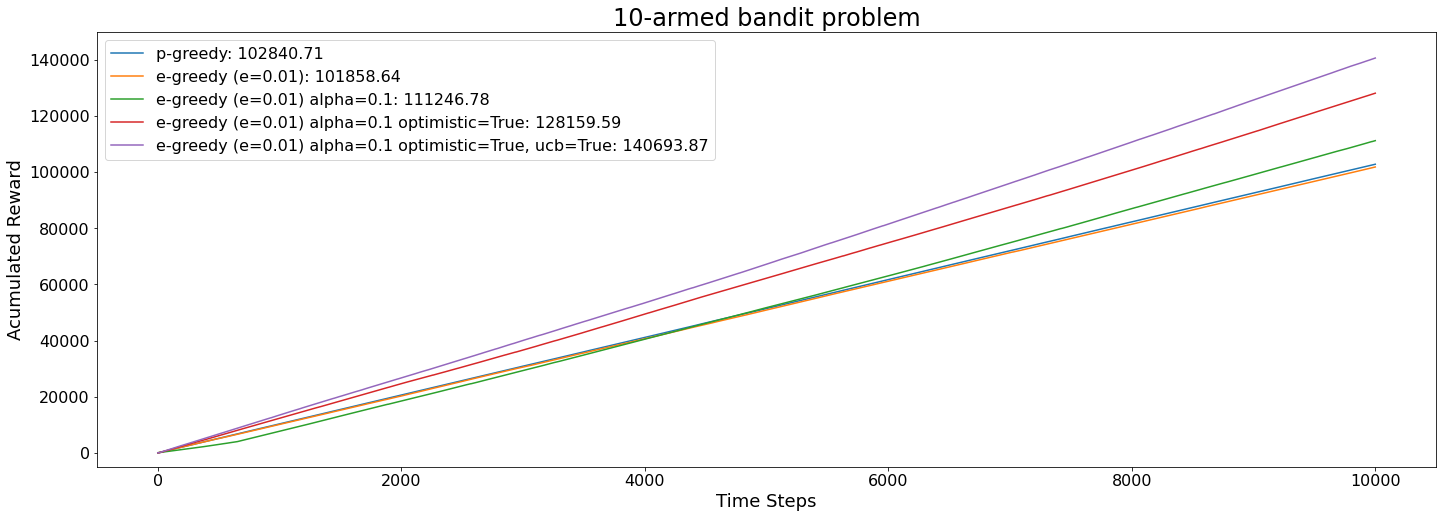

In [41]:
import matplotlib.pyplot as plt

# Greedy: Explore "3" steps, Exploit "10000-3" steps
entity_greedy = init_entity(optimistic=False)
explore_steps = 3
entity_greedy = greedy_method(mode="explore", steps=explore_steps, entity=entity_greedy)
entity_greedy = greedy_method(mode="exploit", steps=10000-explore_steps, entity=entity_greedy)

entity_e_greedy_01 = init_entity(optimistic=False)
entity_e_greedy_01 = greedy_method(mode="explore", steps=explore_steps, entity=entity_e_greedy_01)
entity_e_greedy_01 = greedy_method(mode="epsilon", steps=10000-explore_steps, entity=entity_e_greedy_01, epsilon=0.01)

entity_e_greedy_01_alpha = init_entity(optimistic=False)
entity_e_greedy_01_alpha = greedy_method(mode="explore", steps=explore_steps, entity=entity_e_greedy_01_alpha, same_action_value=False)
entity_e_greedy_01_alpha = greedy_method(mode="epsilon", steps=10000-explore_steps, entity=entity_e_greedy_01_alpha, epsilon=0.01, same_action_value=False)

entity_e_greedy_01_alpha_opt = init_entity(optimistic=True)
entity_e_greedy_01_alpha_opt = greedy_method(mode="explore", steps=explore_steps, entity=entity_e_greedy_01_alpha_opt, same_action_value=False)
entity_e_greedy_01_alpha_opt = greedy_method(mode="epsilon", steps=10000-explore_steps, entity=entity_e_greedy_01_alpha_opt, epsilon=0.01, same_action_value=False)

entity_e_greedy_01_alpha_opt_ucb = init_entity(optimistic=True)
entity_e_greedy_01_alpha_opt_ucb = greedy_method(mode="explore", steps=explore_steps, entity=entity_e_greedy_01_alpha_opt_ucb, same_action_value=False)
entity_e_greedy_01_alpha_opt_ucb = greedy_method(mode="UCB", steps=10000-explore_steps, entity=entity_e_greedy_01_alpha_opt_ucb, epsilon=0.01, same_action_value=False)

plt.figure(figsize=(24, 8))

plt.plot(entity_greedy["acc_reward_record"], label=f"p-greedy: {round(entity_greedy['acc_reward_record'][-1], 2)}")
plt.plot(entity_e_greedy_01["acc_reward_record"], label=f"e-greedy (e=0.01): {round(entity_e_greedy_01['acc_reward_record'][-1], 2)}")
plt.plot(entity_e_greedy_01_alpha["acc_reward_record"], label=f"e-greedy (e=0.01) alpha=0.1: {round(entity_e_greedy_01_alpha['acc_reward_record'][-1], 2)}")
plt.plot(entity_e_greedy_01_alpha_opt["acc_reward_record"], label=f"e-greedy (e=0.01) alpha=0.1 optimistic=True: {round(entity_e_greedy_01_alpha_opt['acc_reward_record'][-1], 2)}")
plt.plot(entity_e_greedy_01_alpha_opt_ucb["acc_reward_record"], label=f"e-greedy (e=0.01) alpha=0.1 optimistic=True, ucb=True: {round(entity_e_greedy_01_alpha_opt_ucb['acc_reward_record'][-1], 2)}")

plt.legend(fontsize=16)
plt.title("10-armed bandit problem", fontsize=24)
plt.xlabel("Time Steps", fontsize=18)
plt.ylabel("Acumulated Reward",fontsize=18)
plt.ylim([-5000, 150000])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()